### 1️⃣ Introduction — 🔍 What is Hyperparameter Tuning?
# 🎯 Overview
**Hyperparameter tuning** is the process of searching for the best set of hyperparameters for a machine learning model.  
- **Hyperparameters** are configuration settings external to the model weights (e.g., `C` and `gamma` for SVM, `n_estimators` for RandomForest).  
- Good tuning improves model performance and generalization.

---

**Why it's important**
- Prevents underfitting/overfitting from bad hyperparameter choices.  
- Automates model selection decisions.  
- Can significantly improve final performance with the same algorithm.

✍️ We'll cover: Grid Search, Random Search, cross-validation, nested CV, advanced approaches, practical tips, code examples, and visualizations.


### 2️⃣ Objectives — 📚 What you'll learn in this notebook
- Intuition & formal definition of hyperparameters vs parameters.  
- Grid Search (exhaustive), Random Search (sampling-based) — how they work step-by-step.  
- Code examples (scikit-learn) and visualizations (heatmaps, scatter).  
- Nested cross-validation for unbiased evaluation.  
- Pipelines + hyperparameter search with preprocessing.  
- Practical advice: ranges, distributions, computational tradeoffs.  
- Equations and notation in Markdown-friendly LaTeX.


### 3️⃣ Formal definitions & math ✏️

- Let dataset $ \mathcal{D} = \{(x_i, y_i)\}_{i=1}^n $.  
- A learning algorithm $ A $ with hyperparameters $ \lambda \in \Lambda $ produces model $ f(x; \theta(\lambda)) $ where $ \theta $ are learned parameters (weights).  
- We seek hyperparameters $ \lambda^* $ that minimize expected loss (risk):

$$
\lambda^* = \arg\min_{\lambda \in \Lambda} \mathbb{E}_{(x,y)\sim P_{data}} \big[ \mathcal{L}(y, f(x; \theta(\lambda))) \big]
$$

- In practice we approximate with cross-validated score $ \hat{R}_{CV}(\lambda) $:

$$
\lambda^* \approx \arg\min_{\lambda \in \Lambda} \hat{R}_{CV}(\lambda)
$$

where 

$$
\hat{R}_{CV}(\lambda) = \frac{1}{K} \sum_{k=1}^K \mathcal{L}(\mathcal{D}_{val}^{(k)}, f_{\lambda}(\mathcal{D}_{train}^{(k)}))
$$

---

**Notes**

- Grid Search: evaluates $ \hat{R}_{CV}(\lambda) $ for every $ \lambda $ on a grid.  
- Random Search: samples $ \lambda \sim P(\Lambda) $ and evaluates a subset.  
- Nested CV: an outer CV for performance estimate + inner CV for tuning to avoid optimistic bias.


### 4️⃣ Grid Search — intuition & step-by-step 🧭

**Intuition:** try every combination from a predefined grid of hyperparameter values.

**Step-by-step**

1. Define parameter grid: $ \Lambda = \{ \lambda_1, \lambda_2, \dots \} $ as a Cartesian product of parameter choices.  
2. For each $ \lambda \in \Lambda $:
   - Perform K-fold CV on training set (or use CV in sklearn).  
   - Compute mean CV score $ \hat{R}_{CV}(\lambda) $.  
3. Choose $ \lambda^* = \arg\max $ (or $ \arg\min $) of CV score.  
4. Refit final model on full training data with $ \lambda^* $.  
5. Evaluate on test set.

**Pros**
- Simple, exhaustive, easy to parallelize.

**Cons**
- Computationally expensive (explodes with dimensions).  
- Wastes evaluations when some hyperparameters are unimportant.


Best params: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score: 0.9640


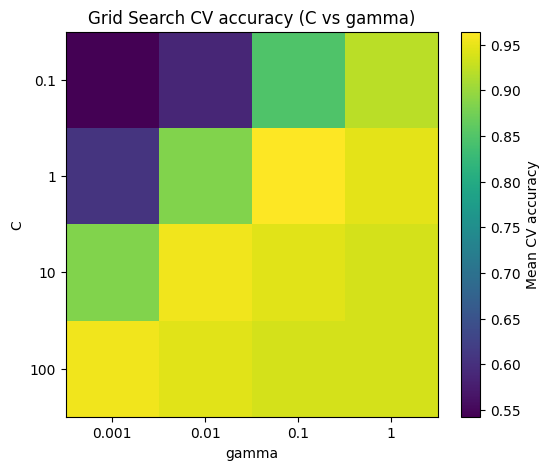

In [6]:
### 5️⃣ Grid Search — runnable example (SVM on Iris) 🧪
# Setup: runs GridSearchCV on SVC, shows heatmap of CV scores.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load data
X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Pipeline: scaling + SVC
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

# Define grid
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
    'svc__kernel': ['rbf']
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score: {:.4f}".format(grid.best_score_))

# Prepare heatmap data for (C, gamma)
scores = grid.cv_results_['mean_test_score'].reshape(len(param_grid['svc__C']), len(param_grid['svc__gamma']))

plt.figure(figsize=(6,5))
plt.imshow(scores, interpolation='nearest', aspect='auto')
plt.colorbar(label='Mean CV accuracy')
plt.xticks(np.arange(len(param_grid['svc__gamma'])), param_grid['svc__gamma'])
plt.yticks(np.arange(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Grid Search CV accuracy (C vs gamma)')
plt.show()


### 6️⃣ Random Search — intuition & why it's powerful 🎯

**Intuition:** instead of evaluating every point on a grid, sample hyperparameter combinations from specified distributions and evaluate those.

**Step-by-step**

1. Define parameter distributions $ P(\lambda) $ (e.g., log-uniform for scale parameters).  
2. Sample $ N $ hyperparameter combinations $ \{\lambda^{(i)}\}_{i=1}^N $.  
3. For each sample, evaluate via CV and keep best.  
4. Refit final model with best found hyperparameters.

**Why often better than grid search**

- If only a subset of hyperparameters matter, random search explores more values per hyperparameter.  
- For $D$ dimensions and a fixed budget, random search often finds near-optimal settings faster.


Best params (random): {'svc__C': np.float64(145.28246637516014), 'svc__gamma': np.float64(0.0007068974950624604), 'svc__kernel': 'rbf'}
Best CV score (random): 0.9640


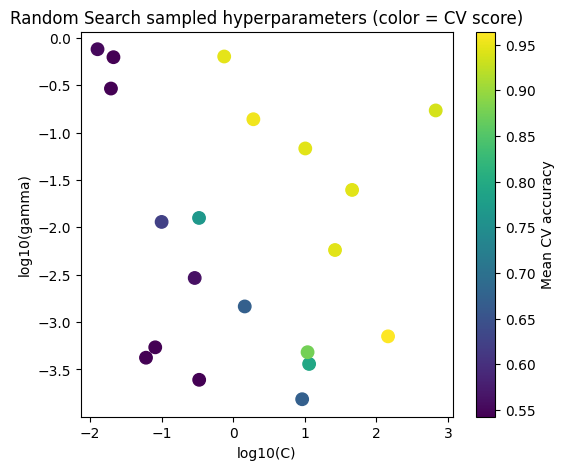

In [7]:
### 7️⃣ Random Search — runnable example (SVM on Iris) 🔁
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# Define distributions
param_dist = {
    'svc__C': loguniform(1e-2, 1e3),     # continuous log-uniform
    'svc__gamma': loguniform(1e-4, 1e-0),
    'svc__kernel': ['rbf']
}

rand = RandomizedSearchCV(pipe, param_dist, n_iter=20, cv=5, n_jobs=-1, random_state=42, return_train_score=True)
rand.fit(X_train, y_train)

print("Best params (random):", rand.best_params_)
print("Best CV score (random): {:.4f}".format(rand.best_score_))

# Scatter plot of sampled points (C vs gamma) with scores
results = pd.DataFrame(rand.cv_results_)
Cs = [c['svc__C'] if isinstance(c, dict) else c for c in results['params']]
gammas = [p['svc__gamma'] for p in results['params']]
scores = results['mean_test_score']

plt.figure(figsize=(6,5))
plt.scatter(np.log10(Cs), np.log10(gammas), c=scores, s=80, cmap='viridis')
plt.colorbar(label='Mean CV accuracy')
plt.xlabel('log10(C)')
plt.ylabel('log10(gamma)')
plt.title('Random Search sampled hyperparameters (color = CV score)')
plt.show()


### 8️⃣ Cross-Validation refresher — 🔄 why CV for tuning?
- CV estimates generalization error reliably by averaging across folds.  
- Common choices: K-fold (K=5 or 10), stratified K-fold for classification.  
- When tuning, always use CV on the training set (or use nested CV) — **never** tune on the test set.

**Notation recap**
- Inner CV: used to select hyperparameters.  
- Outer CV: used to estimate the generalization error of the whole tuning procedure (nested CV).


In [8]:
### 9️⃣ Nested Cross-Validation — code example (unbiased performance estimate)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Use nested CV: outer loop for performance estimate, inner loop for hyperparameter tuning
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# grid defined earlier (param_grid), use GridSearchCV as inner optimizer
nested_scores = cross_val_score(grid, X, y, cv=outer_cv, n_jobs=-1)
print("Nested CV scores:", nested_scores)
print("Mean nested CV score: {:.4f}".format(nested_scores.mean()))


Nested CV scores: [0.96666667 0.96666667 0.93333333 0.96666667 0.9       ]
Mean nested CV score: 0.9467


### 🔟 Pipelines & preprocessing — why include preprocessing inside search?
- Preprocessing (scaling, imputation, encoding) must be part of the cross-validation pipeline to avoid data leakage.  
- Use `Pipeline` or `ColumnTransformer` — then pass the pipeline to `GridSearchCV` / `RandomizedSearchCV`.  
- This ensures parameter selection accounts for the entire transformation + model chain.


In [9]:
### 1️⃣1️⃣ Example: Pipeline with StandardScaler + SVC + GridSearch
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# For tabular data with numeric & categorical columns (toy example uses all numeric)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid2 = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1],
}

gs = GridSearchCV(pipeline, param_grid2, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params (pipeline):", gs.best_params_)


Best params (pipeline): {'svc__C': 1, 'svc__gamma': 0.1}


### 1️⃣2️⃣ Practical advice & best practices 🧭
- **Start coarse, then refine**: use randomized search or a coarse grid first, then narrow ranges.  
- **Use log-scales for scale parameters** (C, gamma, learning rate): sample log-uniform.  
  - Example: \( \text{C} \sim \mathrm{LogUniform}(10^{-3}, 10^3) \).  
- **Limit total evaluations**: set budget (n_iter) for Random Search.  
- **Parallelize**: use `n_jobs=-1` where possible.  
- **Use early stopping for iterative models** (e.g., boosting) to reduce compute.  
- **Nested CV** for reporting final unbiased performance.  
- **Be careful with categorical parameters**: treat as discrete choices.  
- **Record results**: save `cv_results_` for analysis and reproducibility.


C:\Users\prito\AppData\Local\Temp\ipykernel_16296\3430430274.py:9: RuntimeWarning: invalid value encountered in log
  return (np.sin(np.log(C)*2) + np.cos(np.log(g)*3)) * (1 - 0.1*np.log(C+1)*np.log(g+1))
C:\Users\prito\AppData\Local\Temp\ipykernel_16296\3430430274.py:9: RuntimeWarning: divide by zero encountered in log
  return (np.sin(np.log(C)*2) + np.cos(np.log(g)*3)) * (1 - 0.1*np.log(C+1)*np.log(g+1))
C:\Users\prito\AppData\Local\Temp\ipykernel_16296\3430430274.py:9: RuntimeWarning: invalid value encountered in cos
  return (np.sin(np.log(C)*2) + np.cos(np.log(g)*3)) * (1 - 0.1*np.log(C+1)*np.log(g+1))


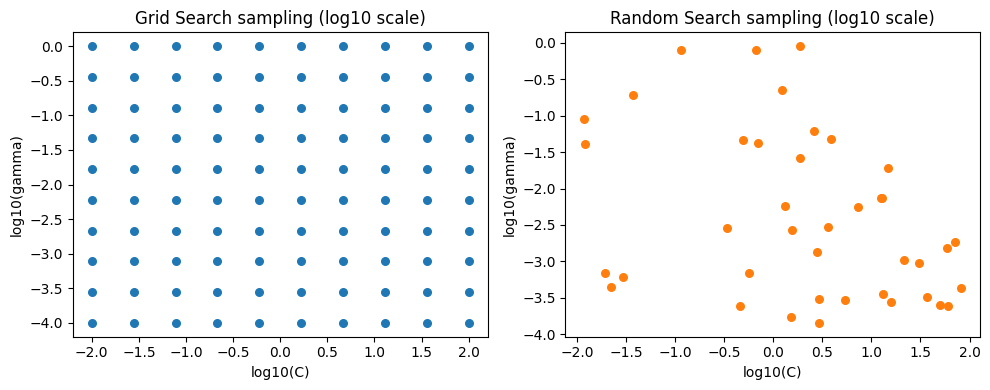

In [10]:
### 1️⃣3️⃣ Visual comparison: Grid vs Random (toy simulation)
# We'll simulate a function of two hyperparams and compare grid vs random sampling coverage
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# synthetic "score" function for visualization
def synth_score(C, g):
    return (np.sin(np.log(C)*2) + np.cos(np.log(g)*3)) * (1 - 0.1*np.log(C+1)*np.log(g+1))

C_grid = np.logspace(-2, 2, 10)
g_grid = np.logspace(-4, 0, 10)
Cg, Gg = np.meshgrid(np.log10(C_grid), np.log10(g_grid), indexing='ij')
Z = synth_score(Cg, Gg)

# grid points
grid_points = np.array([[np.log10(c), np.log10(g)] for c in C_grid for g in g_grid])

# random points
rand_C = 10**(np.random.uniform(-2, 2, 40))
rand_g = 10**(np.random.uniform(-4, 0, 40))
rand_points = np.column_stack((np.log10(rand_C), np.log10(rand_g)))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(grid_points[:,0], grid_points[:,1], label='Grid samples', s=30)
plt.title('Grid Search sampling (log10 scale)')
plt.xlabel('log10(C)'); plt.ylabel('log10(gamma)')
plt.subplot(1,2,2)
plt.scatter(rand_points[:,0], rand_points[:,1], label='Random samples', color='tab:orange', s=30)
plt.title('Random Search sampling (log10 scale)')
plt.xlabel('log10(C)'); plt.ylabel('log10(gamma)')
plt.tight_layout()
plt.show()


### 1️⃣4️⃣ Hyperparameter importance & analysis 🔎
- After searching, analyze `cv_results_` (mean_test_score) to understand sensitivity.  
- Use:
  - Boxplots of score vs parameter value.  
  - Partial dependence / single-parameter plots: fix others to best and vary one parameter to see effect.  
- If expensive, consider **Bayesian Optimization** (e.g., `skopt`, `optuna`) — builds a surrogate model to choose next hyperparameters smartly.


param_svc__C
0.1      0.724802
1.0      0.850198
10.0     0.930632
100.0    0.943874
Name: mean_test_score, dtype: float64


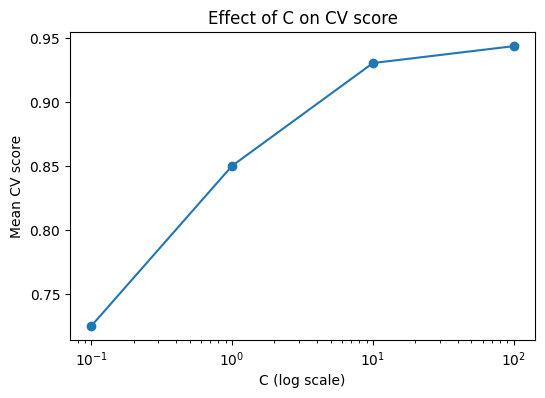

In [11]:
### 1️⃣5️⃣ Example: analyze GridSearch cv_results_ for a parameter
results = pd.DataFrame(grid.cv_results_)
# show mean score per C
grouped = results.groupby('param_svc__C')['mean_test_score'].mean()
print(grouped)

# Plot
plt.figure(figsize=(6,4))
plt.plot(list(grouped.index), grouped.values, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean CV score')
plt.title('Effect of C on CV score')
plt.show()


### 1️⃣6️⃣ When to use which method? ✅

- **Grid Search**: small number of hyperparameters with small, discrete choices; when exhaustive search is feasible.  
- **Random Search**: high-dimensional or continuous hyperparameter spaces; fixed budget; often better first choice.  
- **Bayesian Optimization** (e.g., `optuna`, `skopt`): when evaluations are expensive and you want a smarter search using prior evaluations.  
- **Hyperband / Successive Halving**: for iterative models where you can early-stop bad configurations (e.g., `keras`, `xgboost`).  
- **Nested CV**: whenever you report final performance after tuning (to avoid optimistic bias).


### 1️⃣7️⃣ Summary & References 🧾
**Summary**
- Hyperparameter tuning ≠ training weights. Use CV to estimate performance of hyperparameters.  
- Random Search is often more efficient than Grid Search in many practical settings.  
- Include preprocessing inside pipelines to avoid leakage.  
- Use nested CV for unbiased final evaluation.  
- For expensive evaluations, consider Bayesian/Successive Halving methods.

**Further reading / tools**
- scikit-learn: `GridSearchCV`, `RandomizedSearchCV`, `HalvingGridSearchCV`.  
- Optuna, scikit-optimize (skopt), Ray Tune for advanced optimization.  
- Papers: Bergstra & Bengio (2012) "Random Search for Hyper-Parameter Optimization".

---




### 1️⃣ GridSearchCV vs RandomizedSearchCV — Overview 🔍

In **scikit-learn**, two main classes are used for hyperparameter tuning:

| Feature | GridSearchCV | RandomizedSearchCV |
|---------|-------------|------------------|
| **Search type** | Exhaustive search over all combinations in a grid | Random sampling from specified distributions |
| **Computational cost** | High for large grids (evaluates every combination) | Lower, you can set `n_iter` (number of samples) |
| **Best for** | Small number of hyperparameters with discrete values | High-dimensional or continuous hyperparameter spaces |
| **Flexibility** | Fixed grid only | Can use distributions, e.g., log-uniform for scale parameters |
| **Parallelization** | `n_jobs` supported | `n_jobs` supported |
| **CV integration** | Integrated | Integrated |

---

**Intuition:**
- `GridSearchCV`: tests all combinations. ✅ Exhaustive, but can be slow.  
- `RandomizedSearchCV`: tests `n_iter` random combinations. ✅ Faster, often finds good parameters efficiently.


In [12]:
### 2️⃣ GridSearchCV — Example (SVC)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Pipeline: scaling + SVC
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

# Define parameter grid
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
    'svc__kernel': ['rbf']
}

# GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters (GridSearchCV):", grid.best_params_)
print("Best CV score: {:.4f}".format(grid.best_score_))


Best parameters (GridSearchCV): {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score: 0.9640


In [13]:
### 3️⃣ RandomizedSearchCV — Example (SVC)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Define parameter distributions
param_dist = {
    'svc__C': loguniform(0.01, 100),
    'svc__gamma': loguniform(0.001, 1),
    'svc__kernel': ['rbf']
}

# RandomizedSearchCV
rand = RandomizedSearchCV(pipe, param_dist, n_iter=20, cv=5, n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)

print("Best parameters (RandomizedSearchCV):", rand.best_params_)
print("Best CV score: {:.4f}".format(rand.best_score_))


Best parameters (RandomizedSearchCV): {'svc__C': np.float64(5.456725485601478), 'svc__gamma': np.float64(0.020914981329035603), 'svc__kernel': 'rbf'}
Best CV score: 0.9640


### 4️⃣ Key differences in practice ⚡

- **Exhaustive vs Random:**  
  - GridSearchCV tests all points → guaranteed best on grid.  
  - RandomizedSearchCV tests a subset → faster, often finds near-optimal solution.
- **When to use:**  
  - Small parameter grids → GridSearchCV.  
  - Large or continuous hyperparameter spaces → RandomizedSearchCV.
- **Efficiency:**  
  - RandomizedSearchCV is more efficient when only a few hyperparameters are really important (Bergstra & Bengio, 2012).


### 5️⃣ Tips & Best Practices ✅

1. Always use **cross-validation** (`cv` parameter) to avoid overfitting during hyperparameter search.  
2. Use **pipelines** to include preprocessing inside the search.  
3. For **scale-sensitive hyperparameters** like `C` and `gamma`, sample from **log-uniform distributions**.  
4. Set `n_jobs=-1` to parallelize and save time.  
5. Use **RandomizedSearchCV** for initial tuning if the parameter space is large, then refine with **GridSearchCV** around the best found parameters.
